In [3]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [4]:
matplotlib.rcParams['figure.figsize'] = [10, 5]

Here we will explain what we can do when we deal with categorical variables. That is variables that are not numeric.

## Labelizer

The easiest way to deal with them is to just transform them into numbers. Let's look at the following example.

__Example__ Let's assume that one of our column contains names of animals. There are three of them _dog_, _cat_ and _horse_. We can then assign them numbers: 0, 1 and 2. Hence we have transformed categorical variable into numeric one. Let's look how we can do this in `python`.

So let's put all out classes as a list.

In [5]:
categories = ["dog", "cat", "horse"]

Now, our categories have a numeration. That is on order in the list. So we can easily create a dictionary that transform an animal name into a number:
* dog to 0
* cat to 1
* horse to 2.

In python it can be done as follows.

In [6]:
col2num = {categories[i]: i for i in range(len(categories))}

Now let's see how we can transform a column of a `DataFrame` using this dictionary.

In [7]:
animals_df = pd.DataFrame({"name": ["dog", "dog", "cat", "dog", "horse", "cat", "dog"]})
animals_df["name_label"] = animals_df["name"].apply(lambda name: col2num[name])
animals_df

,name,name_label
0,dog,0
1,dog,0
2,cat,1
3,dog,0
4,horse,2
5,cat,1
6,dog,0


The most important problem with this kind of encoding is that there is no natural order of those categories. There is reason why _cat_ should go between _dog_ and _horse_. This could cause a problem when we try to do linear regression. We will see it in the following example.

### Example

Let's train a model of prices of houses using `Neighborhood` variable. 

In [8]:
houses = pd.read_csv("data/house-prices-advanced-regression-techniques/train.csv", index_col="Id")

target_col = "SalePrice"
categorical_column = "Neighborhood"
Xy = houses[[categorical_column, target_col]]
X = Xy.drop(target_col, axis=1)
y = Xy[target_col]

X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, random_state=666, test_size=0.2)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, random_state=667, test_size=0.25)

In [9]:
classes = X[categorical_column].unique()
col2num = {classes[i]: i for i in range(len(classes))}
X_train[categorical_column + "_label"] = X_train[categorical_column].apply(lambda cls: col2num[cls])
X_dev[categorical_column + "_label"] = X_dev[categorical_column].apply(lambda cls: col2num[cls])

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression()
reg.fit(X_train[[categorical_column + "_label"]], y_train)
y_dev_hat = reg.predict(X_dev[[categorical_column + "_label"]])
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

79925.19665925231


So let's see why adding sort of random numbers to categories is not the best idea. We will plot the prediction and labels.

Text(0, 0.5, 'Sale Price')

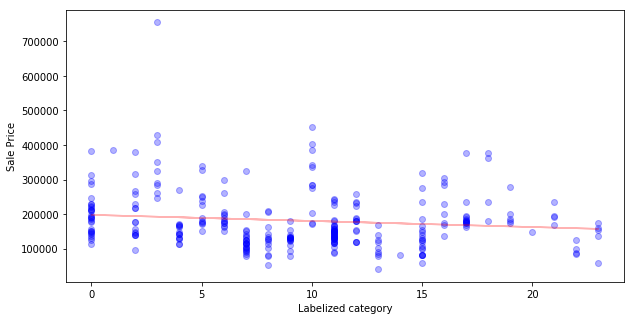

In [11]:
# Ploting real data y (blue)
plt.scatter(X_dev[[categorical_column + "_label"]], y_dev, alpha=0.3, c="blue")
# versus predicted y_hat (red)


plt.plot(X_dev[[categorical_column + "_label"]], y_dev_hat, alpha=0.3, c="red")

plt.xlabel("Labelized category")
plt.ylabel("Sale Price")

We see that prediction is almost constant and we probably should reorder labels in a different ways. There two ways of solving it that we will discuss here.
1. We could labelized categories in a way that they do not have an order. We can do this using One-Hot-Encoding.
2. Labelized categories by numbers that makes sense.

## One-Hot-Encoding 

Let's comeback to animals example. The way to labelized categories in the way that they will not have any order is called One-Hot-Encoding. It is done by creating that many columns as categories we have and fill them with zeros, except the one that corresponds the category. So encode categories as follows:
* dog to `[1, 0, 1]`
* cat to `[0, 1, 0]`
* horse to `[0, 0, 1]`.

In [12]:
def label_one_hot_encoding(series, dict_length=None):
    if dict_length is None:
        dict_length = len(series.unique())
    return np.eye(dict_length)[series]

print(animals_df)
print(label_one_hot_encoding(animals_df["name_label"], len(categories)))

    name  name_label
0    dog           0
1    dog           0
2    cat           1
3    dog           0
4  horse           2
5    cat           1
6    dog           0
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


Now, let's train it and see it it's get better.

In [13]:
dict_length = len(X_train[categorical_column + "_label"].unique())

In [14]:
reg.fit(label_one_hot_encoding(X_train[categorical_column + "_label"], dict_length), y_train)
y_dev_hat = reg.predict(label_one_hot_encoding(X_dev[categorical_column + "_label"], dict_length))
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

58997.45600409801


## Value encoding

Another way of encoding categories is to use average values of target variable. Actually in this situation we will get exactly the same predictions `y_dev_hat`. The most important think to remember is to use `X_train` and `y_train`. Let's see with the following code what it means.

In [15]:
category_value_df = X_train[[categorical_column]]
category_value_df[categorical_column+"_value"] = y_train
category_value_df = category_value_df.groupby(categorical_column, as_index=False).mean()
category_value_df.head()

,Neighborhood,Neighborhood_value
0,Blmngtn,191537.400000
1,Blueste,124000.000000
2,BrDale,109250.000000
3,BrkSide,123232.142857
4,ClearCr,215843.058824


In [16]:
y_dev_hat_value_encoded = \
    X_dev.merge(category_value_df, how="left", on=categorical_column)[[categorical_column+"_value"]]
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

58997.45600409801


## Putting all together

In [17]:
columns = ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 
'TotalBsmtSF', "Neighborhood", "ExterQual"]

target_col = "SalePrice"
X = houses[columns]
y = houses[target_col]

X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, random_state=666, test_size=0.2)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, random_state=667, test_size=0.25)

In [18]:
class Labelizer:
    
    def __init__(self, categories):
        self.categories = categories
        self.cat2num = {}
        self.num2cat = {}
        
    def generate_dicts(self):
        self.cat2num = {self.categories[i]: i for i in range(len(self.categories))}
        self.num2cat = {i: self.categories[i] for i in range(len(self.categories))}
        
    def fit(self):
        self.generate_dicts()
        return self
        
    def transform(self, series):
        return series.apply(lambda cat: self.cat2num[cat])
    
labelizer_Neighborhood = Labelizer(X_train["Neighborhood"].unique()).fit()  
labelizer_ExterQual = Labelizer(X_train["ExterQual"].unique()).fit()

def labelize_X(X):
    labelized_X = X.drop(["Neighborhood", "ExterQual"], axis=1)
    labelized_X["Neighborhood_labelized"] = labelizer_Neighborhood.transform(X["Neighborhood"])
    labelized_X["ExterQual_labelized"] = labelizer_ExterQual.transform(X["ExterQual"])
    return labelized_X

X_train_labelized = labelize_X(X_train)
X_dev_labelized = labelize_X(X_dev)

reg.fit(X_train_labelized, y_train)
y_dev_hat = reg.predict(X_dev_labelized)
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

42536.38809365479


In [19]:
A = np.array([[1, 2], [3, 4], [5, 6]])
B = np.array([[7], [8], [9]])
C = np.array([[11, 12], [13, 14], [16, 15]])
np.concatenate([A, B, C], axis=1)

array([[ 1,  2,  7, 11, 12],
       [ 3,  4,  8, 13, 14],
       [ 5,  6,  9, 16, 15]])

In [20]:
class OneHotEncoderWithLabelizer:
    
    def __init__(self, categories):
        self.categories = categories
        self.labelizer = Labelizer(categories)
            
    def fit(self):
        self.labelizer.fit()
        return self
        
    def transform(self, series):
        series_labelized = self.labelizer.transform(series)
        return np.eye(len(self.categories))[series_labelized]
    
one_hot_encoder_Neighborhood = OneHotEncoderWithLabelizer(X_train["Neighborhood"].unique()).fit()  
one_hot_encoder_ExterQual = OneHotEncoderWithLabelizer(X_train["ExterQual"].unique()).fit()

def one_hot_encode_X(X):
    X_other = X.drop(["Neighborhood", "ExterQual"], axis=1).as_matrix()
    neighborhood_encoded = one_hot_encoder_Neighborhood.transform(X["Neighborhood"])
    exterQual_encoded = one_hot_encoder_ExterQual.transform(X["ExterQual"])
    return np.concatenate([X_other, neighborhood_encoded, exterQual_encoded], axis=1)

X_train_encoded = one_hot_encode_X(X_train)
X_dev_encoded = one_hot_encode_X(X_dev)

reg.fit(X_train_encoded, y_train)
y_dev_hat = reg.predict(X_dev_encoded)
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

38502.670900758276


In [21]:
import string

class ValueEncoder:
    
    def __init__(self, cat_colname=None, value_colname=None, agg_function='mean',):
        self.agg_function = agg_function
        self.cat_colname = cat_colname if cat_colname is not None else\
            ''.join(np.random.choice(list(string.ascii_lowercase + string.digits)) for _ in range(10))
        self.value_colname = value_colname if value_colname is not None else\
            self.cat_colname + "_" + self.agg_function
        self.cat_value_df = None
            
    def fit(self, cat_series, value_series):
        cat_value_df = pd.DataFrame({
            self.cat_colname: cat_series,
            self.value_colname: value_series
        })
        self.cat_value_df = cat_value_df\
            .groupby(self.cat_colname, as_index=False)\
            .agg(self.agg_function)
        return self
        
    def transform(self, cat_series):
        return pd.DataFrame({self.cat_colname:cat_series})\
            .merge(self.cat_value_df, on=self.cat_colname, how="left")[self.value_colname]

value_encoder_Neighborhood = ValueEncoder("Neighborhood")\
   .fit(X_train["Neighborhood"], y_train)  
value_encoder_ExterQual = ValueEncoder("ExterQual")\
   .fit(X_train["ExterQual"], y_train)

def value_encode_X(X):
    encoded_X = X.drop(["Neighborhood", "ExterQual"], axis=1).reset_index(drop=True)
    encoded_X["Neighborhood_encoded"] = value_encoder_Neighborhood.transform(X["Neighborhood"])
    encoded_X["ExterQual_encoded"] = value_encoder_ExterQual.transform(X["ExterQual"])
    return encoded_X

X_train_encoded = value_encode_X(X_train)
X_dev_encoded = value_encode_X(X_dev)
reg.fit(X_train_encoded, y_train)
y_dev_hat = reg.predict(X_dev_encoded)
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

40200.74117925291
